<a href="https://colab.research.google.com/github/sowmini4901/SceneSegmentation/blob/main/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install focal-loss

In [ ]:
import pickle
import torch
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import os
from sklearn import preprocessing
from focal_loss import BinaryFocalLoss

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
folder='/content/gdrive/MyDrive/movies/data'
with open('/content/gdrive/MyDrive/movies/data/tt0052357.pkl','rb') as f:
    data=pickle.load(f)

print(type(data))
x=list(data)
print(x)

<class 'dict'>
['place', 'cast', 'action', 'audio', 'scene_transition_boundary_ground_truth', 'shot_end_frame', 'scene_transition_boundary_prediction', 'imdb_id']


In [ ]:
#boolean vector for scene transitioning. Used for training the neural network which is ground truth
a=data['scene_transition_boundary_ground_truth']
print(type(a))
a=a.data.numpy()
print(a)

<class 'torch.Tensor'>
[False False False ... False False  True]


In [ ]:
print(type(a))
len(a)

<class 'numpy.ndarray'>


1100

In [ ]:
#each shot boundary for a scene.
b=data['scene_transition_boundary_prediction']
print(type(b))
b=b.data.numpy()
print(b)


<class 'torch.Tensor'>
[0.     0.     0.4878 ... 0.     0.     0.    ]


In [ ]:
print(type(b))
len(b)

<class 'numpy.ndarray'>


1100

In [ ]:
c=data['shot_end_frame']
print(type(c))
c=c.data.numpy()
print(c)

<class 'torch.Tensor'>
[    45   1149   1437 ... 183782 184354 184794]


In [ ]:
print(type(c))
len(c)

<class 'numpy.ndarray'>


1101

In [ ]:
place=data['place']
print(type(place))
place=place.data.numpy()
len(place)
placeSize=place.shape[1]
print(place.shape[1])

<class 'torch.Tensor'>
2048


In [ ]:
print(type(place))
print(place[0])
len(place)
print(place.shape)
#each feature vector length 2048. Total 1101 datapoints.

<class 'numpy.ndarray'>
[0.06155615 0.10176984 0.05208468 ... 0.06714813 0.00159654 0.00959668]
(1101, 2048)


In [ ]:
cast=data['cast']
print(type(cast))
cast=cast.data.numpy()
castSize=cast.shape[1]
print(cast.shape[1])

<class 'torch.Tensor'>
512


In [ ]:
print(type(cast))
len(cast)

<class 'numpy.ndarray'>


1101

In [ ]:
action=data['action']
print(type(action))
action=action.data.numpy()
actionSize=action.shape[1]
print(action.shape[1])

<class 'torch.Tensor'>
512


In [ ]:
print(type(action))

<class 'numpy.ndarray'>


In [ ]:
audio=data['audio']
print(type(audio))
audio=audio.data.numpy()
audioSize=audio.shape[1]
print(audio.shape[1])

<class 'torch.Tensor'>
512


In [ ]:
print(type(audio))
len(audio)
print(audio.shape)

<class 'numpy.ndarray'>
(1101, 512)


In [ ]:
print(data['imdb_id'])

print(type(data['imdb_id']))
imdb=data['imdb_id']
len(data['imdb_id'])

tt0052357
<class 'str'>


9

In [ ]:
shotendFrame=data['shot_end_frame']
print(type(shotendFrame))
shotendFrame=shotendFrame.data.numpy()
print(shotendFrame)

<class 'torch.Tensor'>
[    45   1149   1437 ... 183782 184354 184794]


In [ ]:
print(type(shotendFrame))
print(shotendFrame[1])

<class 'numpy.ndarray'>
1149


In [ ]:
dict1=dict([('scene_transition_boundary_ground_truth',a),('scene_transition_boundary_prediction',b),('shot_end_frame',c),('imdb_id',imdb)])
print(list(dict1))

['scene_transition_boundary_ground_truth', 'scene_transition_boundary_prediction', 'shot_end_frame', 'imdb_id']


In [ ]:
#
x=np.hstack((place,cast,action,audio))
print(x.shape)
#no of columns
print(x[0].shape)
#no.of rows
N=x.shape[0]
print(x.shape[0])
y = data['scene_transition_boundary_ground_truth']

(1101, 3584)
(3584,)
1101


In [ ]:
k=0
j=0
# N = x.shape[0] #changed from x_scaled
x_fold = np.zeros((N - 1, x.shape[1])) #changed from x_scaled
for i in range(N - 1):
    x_fold[i,:] = np.hstack((x[i,:])) #changed from x_scaled
    
if (j == 0):
    X = x_fold
    Y = y
else:
    X = np.concatenate((X, x_fold), axis = 0)
    Y = np.concatenate((Y, y))
    
j = j + 1
k = k + 1


In [ ]:
print(X.shape[1])
print(X)

print(Y.shape)
print(Y)

3584
[[ 0.06155615  0.10176984  0.05208468 ... -0.08285517 -0.09114611
  -0.1050798 ]
 [ 0.05211007  0.13151902  0.04764145 ... -0.06822268 -0.0753056
  -0.08308809]
 [ 0.08774771  2.48847365  0.05433211 ... -0.03319887 -0.03856922
  -0.04540908]
 ...
 [ 0.2964682   0.52283287  0.97852695 ... -0.01917431 -0.02224307
  -0.02377244]
 [ 0.12348853  0.44956958  0.24555996 ... -0.0135067  -0.04963969
  -0.05133732]
 [ 0.01962076  0.72867876  0.24324328 ... -0.02716186 -0.05924841
  -0.06544846]]
torch.Size([1100])
tensor([False, False, False,  ..., False, False,  True])


In [ ]:
M = Y.shape[0]
Y_gt = np.zeros((M), dtype = np.uint8)
for i in range(M):
    if(Y[i] == True):
        Y_gt[i] = 1
    elif(Y[i] == False):
        Y_gt[i] = 0

In [ ]:
array_dims = np.zeros((4), dtype = np.int32)
array_dims[0] = placeSize
array_dims[1] = castSize #feat1_size + feat2_size
array_dims[2] = actionSize #feat1_size + feat2_size + feat3_size
array_dims[3] = audioSize #feat1_size + feat2_size + feat3_size + feat4_size
# array_dims[4] = array_dims[0] #array_dims[3] + feat1_size
# array_dims[5] = array_dims[1] #array_dims[3] + feat1_size + feat2_size
# array_dims[6] = array_dims[2] #array_dims[3] + feat1_size + feat2_size + feat3_size
# array_dims[7] = array_dims[3] #a

In [ ]:
inputs = tf.keras.layers.Input(shape = (X.shape[1]))
x1, x2, x3, x4 = tf.split(inputs, array_dims, axis = 1)

print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 3584), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
x1_r = tf.keras.layers.Reshape((placeSize, 1))(x1)
#x1_b = tf.keras.layers.BatchNormalization(axis=1)(x1_r)

# x5_r = tf.keras.layers.Reshape((placeSize, 1))(x5)
# #x5_b = tf.keras.layers.BatchNormalization(axis=1)(x5_r)

#x2b = tf.keras.layers.BatchNormalization(axis=1)(x2)
x2_conc = tf.keras.layers.concatenate([x2, x2, x2, x2], axis = 1) # create vectors of size (None, 2048) from size (None, 512)
x2_r = tf.keras.layers.Reshape((placeSize, 1))(x2_conc)
print(x2_r.shape)

#x3b = tf.keras.layers.BatchNormalization(axis=1)(x3)
x3_conc = tf.keras.layers.concatenate([x3, x3, x3, x3], axis = 1)
x3_r = tf.keras.layers.Reshape((placeSize, 1))(x3_conc)
print(x3_r.shape)

#x4b = tf.keras.layers.BatchNormalization(axis=1)(x4)
x4_conc = tf.keras.layers.concatenate([x4, x4, x4, x4], axis = 1)
x4_r = tf.keras.layers.Reshape((placeSize, 1))(x4_conc)
print(x4_r.shape)

# #x6b = tf.keras.layers.BatchNormalization(axis=1)(x6)
# x6_conc = tf.keras.layers.concatenate([x6, x6, x6, x6], axis = 1) # create vectors of size (None, 2048) from size (None, 512)
# x6_r = tf.keras.layers.Reshape((placeSize, 1))(x6_conc)
# print(x6_r.shape)

# #x7b = tf.keras.layers.BatchNormalization(axis=1)(x7)
# x7_conc = tf.keras.layers.concatenate([x7, x7, x7, x7], axis = 1)
# x7_r = tf.keras.layers.Reshape((placeSize, 1))(x7_conc)
# print(x7_r.shape)

# #x8b = tf.keras.layers.BatchNormalization(axis=1)(x8)
# x8_conc = tf.keras.layers.concatenate([x8, x8, x8, x8], axis = 1)
# x8_r = tf.keras.layers.Reshape((placeSize, 1))(x8_conc)
# print(x8_r.shape)

shot_1 = tf.keras.layers.concatenate([x1_r, x2_r, x3_r, x4_r], axis = 2) # create a vector of size (None, 2048, 4)
print(shot_1.shape)

# shot_2 = tf.keras.layers.concatenate([x5_r, x6_r, x7_r, x8_r], axis = 2) # create a vector of size (None, 2048, 4)
# print(shot_2.shape)

(None, 2048, 1)
(None, 2048, 1)
(None, 2048, 1)
(None, 2048, 4)


In [ ]:
# building VGG net(standard architecture)
conv1 = tf.keras.Sequential()
conv1.add(tf.keras.layers.Reshape((1, placeSize, 4)))

conv1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 2048, 4)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 2048, 64)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.MaxPool2D(pool_size=(1,2),strides=(2,2)))  #input size(none,1,2048,64)


conv1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 1024, 64)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 1024,64)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.MaxPool2D(pool_size=(1,2),strides=(2,2)))   #input size(none,1,512,128)


conv1.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 512, 128)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 512, 128)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 512, 128)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.MaxPool2D(pool_size=(1,2),strides=(2,2))) #output size (None, 1, 256, 256)

conv1.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 256, 256)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())


conv1.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 256, 256)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 256, 256)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.MaxPool2D(pool_size=(1,2),strides=(2,2))) #output size (None, 1, 128, 512)

conv1.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 128, 512)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())


conv1.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 128, 512)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 128, 512)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.MaxPool2D(pool_size=(1,2),strides=(2,2))) #output size (None, 1, 64, 512)
conv1.add(tf.keras.layers.MaxPool2D(pool_size=(1,2),strides=(2,2))) #output size (None, 1, 32, 512)

conv1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 1), strides=1, padding='same', activation='linear')) #input size (None, 1, 32, 512)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())

conv1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 3), strides=1, padding='same', activation='linear')) #input size (None, 1, 32, 512)
conv1.add(tf.keras.layers.BatchNormalization(axis=3))
conv1.add(tf.keras.layers.ReLU())#input size (None, 1, 32, 64)


encoded_left = conv1(shot_1)

print(conv1.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 1, 2048, 4)        0         
                                                                 
 conv2d (Conv2D)             (None, 1, 2048, 64)       832       
                                                                 
 batch_normalization (BatchN  (None, 1, 2048, 64)      256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 1, 2048, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 2048, 64)       12352     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 2048, 64)      256       
 hNormalization)                                        

In [ ]:

flat = tf.keras.layers.Flatten()(encoded_left) #output size (None, 65536)
d1 = tf.keras.layers.Dropout(rate=0.2)(flat)
# d2 = tf.keras.layers.Dense(, activation='relu')(d1)
# d2r = tf.keras.layers.Dropout(rate=0.2)(d2)
# d3 = tf.keras.layers.Dense(2048, activation='relu')(d2r)
# d3r = tf.keras.layers.Dropout(rate=0.2)(d3)
# output = tf.keras.layers.Dense(1, activation = 'softmax')(d3r)

d2 = tf.keras.layers.Dense(30, activation='relu', kernel_regularizer='l1', bias_regularizer='l1')(flat)
#d2r = tf.keras.layers.Dropout(rate=0.3)(d2)
d2d = tf.keras.layers.BatchNormalization(axis=1)(d2)

d3 = tf.keras.layers.Dense(10, activation='relu', kernel_regularizer='l1', bias_regularizer='l1')(d2d)
#d3r = tf.keras.layers.Dropout(rate=0.3)(d3)
d3d = tf.keras.layers.BatchNormalization(axis=1)(d3)

output = tf.keras.layers.Dense(2, activation = 'softmax')(d3d)

model = tf.keras.Model(inputs = inputs, outputs = output)
opt = tf.keras.optimizers.SGD(learning_rate = 0.001)
model.compile(optimizer = opt, loss = BinaryFocalLoss(pos_weight = 9, gamma = 2.5), metrics=[tf.keras.metrics.Accuracy()]) #BinaryFocalLoss(pos_weight=7, gamma=4)


In [ ]:
print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")


In [ ]:
# model = tf.keras.Model(inputs = inputs, outputs = output)
# opt = tf.keras.optimizers.Adam(learning_rate=0.02)
# # loss1 = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# # model.compile(optimizer = opt, loss = loss1(Y_gt,output), metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=False)])
# # model.compile(optimizer = 'adam', loss = tf.keras.losses.binary_crossentropy(Y_gt, output), metrics=[tf.keras.metrics.Accuracy()])
# # model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])

# # opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

# model.compile(optimizer = opt, loss = BinaryFocalLoss(pos_weight = 70, gamma=1.5), metrics=[tf.keras.metrics.Accuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3584)]       0           []                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 2048),       0           ['input_1[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 2048)         0           ['tf.split[0][1]',           

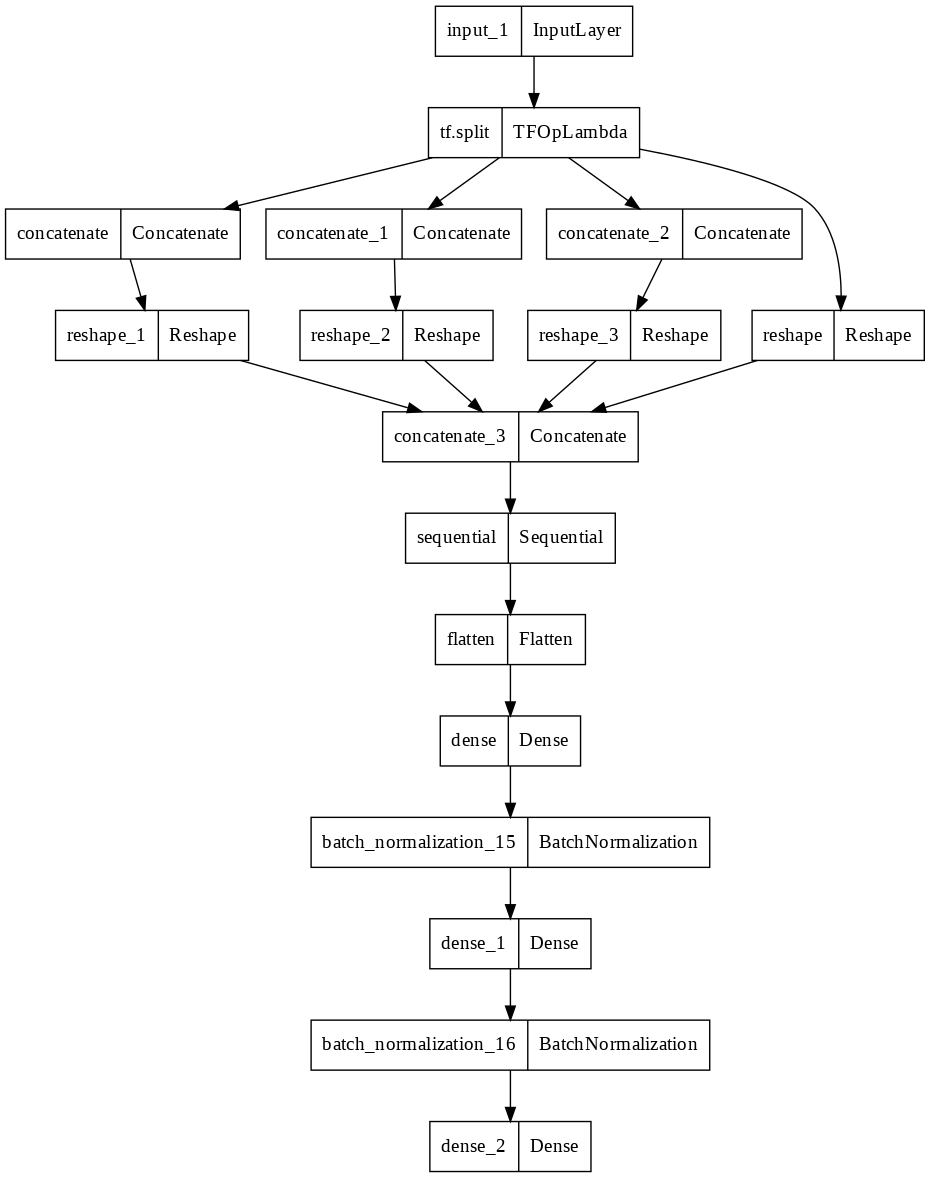

In [ ]:
tf.keras.utils.plot_model(model, to_file='cnn_VGG.png', dpi=100)

In [ ]:
# training_log = 'crossval_fold_' + '.txt'
# csv_logger = tf.keras.callbacks.CSVLogger(training_log, append = True, separator=' ')
# metrics = model.fit(X, Y_gt, epochs=5, validation_split= 0.2, verbose=2, batch_size = 32)
# somex=X[ :, :3584]

training_log = folder + '/' + 'softmax_final_1' + '.txt'
print(training_log)
csv_logger = tf.keras.callbacks.CSVLogger(training_log, append = True, separator=' ')
metrics = model.fit(X, tf.one_hot(Y_gt, depth=2), epochs=3, validation_split= 0.2, verbose=2, batch_size = 64, callbacks=[csv_logger],shuffle=True)

model_ID = folder +  '/' + 'sigmoid_final_1' + '.h5'
print(model_ID)
tf.keras.models.save_model(model,model_ID)


/content/gdrive/MyDrive/movies/data/softmax_final_1.txt
Epoch 1/3
14/14 - 145s - loss: 18.2677 - accuracy: 0.0000e+00 - val_loss: 17.5589 - val_accuracy: 0.0000e+00 - 145s/epoch - 10s/step
Epoch 2/3
14/14 - 143s - loss: 17.8704 - accuracy: 0.0000e+00 - val_loss: 17.4614 - val_accuracy: 0.0000e+00 - 143s/epoch - 10s/step
Epoch 3/3
14/14 - 145s - loss: 17.5542 - accuracy: 0.0000e+00 - val_loss: 17.3760 - val_accuracy: 0.0000e+00 - 145s/epoch - 10s/step
/content/gdrive/MyDrive/movies/data/sigmoid_final_1.h5


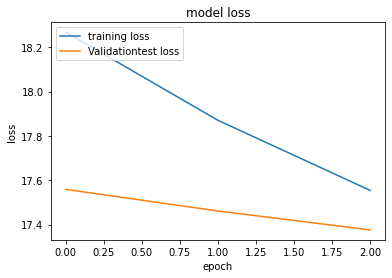

In [ ]:
plt.plot(metrics.history['loss'])
plt.plot(metrics.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'Validationtest loss'], loc='upper left')
plt.show()